# Uso avanzado de los valores SHAP

## Recapitulación

Comenzamos por conocer la importancia de la permutación y los diagramas de dependencia parcial para obtener una visión general de lo que el modelo ha aprendido.

Luego aprendimos sobre los valores SHAP para desglosar los componentes de las predicciones individuales.

Ahora expandiremos los valores SHAP y veremos que la agregación de muchos valores SHAP puede proporcionar alternativas más detalladas a la importancia de la permutación y diagramas de dependencia parcial.

## Revisión de los valores SHAP

Los valores Shap muestran cuánto una característica dada cambió nuestra predicción (en comparación con si hicimos esa predicción en algún valor de referencia de esa característica).

Por ejemplo, considera un modelo ultra simple:
 $$y = 4 * x1 + 2 * x2$$
 
Si $x1$ toma el valor 2, en lugar de un valor de referencia de 0, entonces nuestro valor SHAP para $x1$ sería 8 (de 4 a 2).

Estos son más difíciles de calcular con los modelos sofisticados que utilizamos en la práctica. Pero a través de cierta inteligencia algorítmica, los valores de Shap nos permiten descomponer cualquier predicción en la suma de los efectos de cada valor de la característica, produciendo un gráfico como este:

![Imgur](https://i.imgur.com/JVD2U7k.png)

[Link para vista zoom](https://i.imgur.com/JVD2U7k.png)*

Además de este buen desglose para cada predicción, la [Biblioteca de Shap](https://github.com/slundberg/shap) ofrece excelentes visualizaciones de grupos de valores de Shap. Nos centraremos en dos de estas visualizaciones. Estas visualizaciones tienen similitudes conceptuales con la importancia de la permutación y gráficos de dependencia parcial.

## Resumen de gráficos

[La importancia de la permutación](https://www.kaggle.com/dansbecker/permutation-importance) es excelente porque creó medidas numéricas simples para ver qué características son importantes para un modelo. Esto nos ayudó a hacer fácilmente comparaciones entre características y puede presentar los gráficos resultantes a audiencias no técnicas.

Pero no te dice qué importancia tienen las características. Si una característica tiene una importancia de permutación media, eso podría significar que tiene:

- un gran efecto para algunas predicciones, pero ningún efecto en general, o
- un efecto medio para todas las predicciones.

Los diagramas de resumen de SHAP nos dan una vista panorámica de la importancia de la característica y lo que la impulsa. Vamos a caminar a través de un diagrama de ejemplo para los datos de fútbol:

![Imgur](https://i.imgur.com/Ew9X3su.png)

Esta trama está hecha de muchos puntos. Cada punto tiene tres características:
- La vertical muestra qué característica está representando
- El color muestra si esa característica era alta o baja para esa fila del conjunto de datos
- La ubicación horizontal muestra si el efecto de ese valor causó una predicción mayor o menor.

Por ejemplo, el punto en la parte superior izquierda fue para un equipo que anotó pocos goles, lo que reduce la predicción en 0.25.

Algunas cosas que deberías poder distinguir fácilmente:
- El modelo ignoró las características `Red` y `Yellow & Red`.
- Por lo general, la tarjeta amarilla no afecta la predicción, pero hay un caso extremo en el que un valor alto causó una predicción mucho más baja.
- Los valores altos de Gol anotado causaron predicciones más altas y los valores bajos causaron predicciones bajas

Si busca el tiempo suficiente, hay mucha información en este gráfico. Te enfrentarás a algunas preguntas para probar cómo las lees en el ejercicio.

## Resumen de gráficos en código

Ya has visto el código para cargar los datos de fútbol:

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('./data/fifa-2018-match-statistics/FIFA 2018 Statistics.csv')
y = (data['Man of the Match'] == "Yes")  # Convierte la cadena "Yes"/"No" a binario
feature_names = [i for i in data.columns if data[i].dtype in [np.int64, np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

Obtenemos los valores SHAP para todos los datos de validación con el siguiente código. Es lo suficientemente corto como se explica en los comentarios.

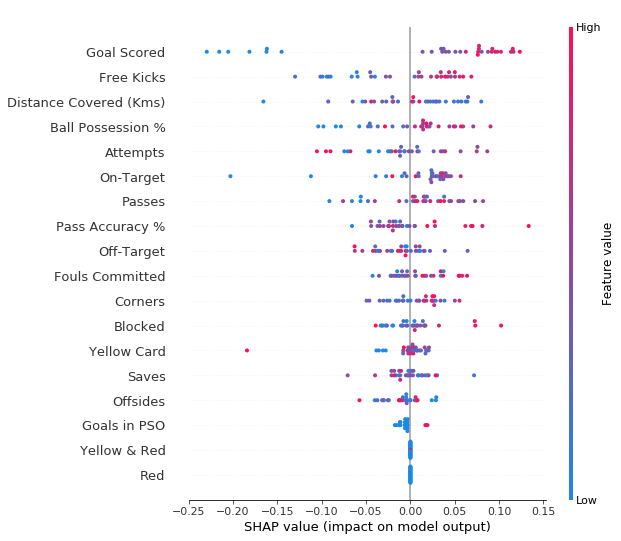

In [2]:
import shap  # librería usada para calcular los valores SHAP

%matplotlib inline

# Crea el objeto que puede calcular valores shap
explainer = shap.TreeExplainer(my_model)

# Calcula los valores shap. Esto es lo que se dibujará
# Calcula shap_values para todos los val_X en lugar de una única fila, para tener más datos para el gráfico
shap_values = explainer.shap_values(val_X)

# Hacemos el gráfico.
shap.summary_plot(shap_values[1], val_X)

El código no es demasiado complejo. Pero hay algunas advertencias.

+ Al dibujar, llamamos a `shap_values [1]`. Por problemas de clasificación, hay una matriz separada de valores SHAP para cada resultado posible. En este caso, indexamos para obtener los valores SHAP para la predicción de "Verdadero".
+ El cálculo de los valores SHAP puede ser lento. No es un problema aquí, porque este conjunto de datos es pequeño. Pero deberás tener cuidado al ejecutarlo con conjuntos de datos de tamaño razonable. La excepción es cuando se usa un modelo `xgboost`, para el cual SHAP tiene algunas optimizaciones y que, por lo tanto, es mucho más rápido.

Esto proporciona una gran visión general del modelo, pero es posible que deseemos profundizar en una sola función. Ahí es donde entran en juego los diagramas de contribución de dependencia SHAP.

## Diagramas de contribución de dependencia SHAP

Anteriormente hemos usado diagramas de dependencia parcial para mostrar cómo una característica única afecta las predicciones. Son interesantes y relevantes para muchos casos de uso del mundo real. Además, con un poco de esfuerzo, pueden explicarse a una audiencia no técnica.

Pero hay mucho que no muestran. Por ejemplo, ¿cuál es la distribución de los efectos? ¿Es el efecto de tener un cierto valor bastante constante, o varía mucho dependiendo de los valores de otras características? Las gráficas de contribución de dependencia SHAP brindan una visión similar a la de los PDP, pero agregan muchos más detalles.

![Imgur](https://i.imgur.com/uQ2JmBm.png)

Comenzaremos por enfocarnos en la forma y volveremos a colorear en un minuto. Cada punto representa una fila de los datos. La ubicación horizontal es el valor real del conjunto de datos, y la ubicación vertical muestra lo que hizo ese valor con la predicción. El hecho de que esto se incline hacia arriba dice que cuanto más tengas el balón, mayor será la predicción del modelo para ganar el premio *Hombre del Año*.

La propagación sugiere que otras características deben interactuar con Ball Possession%. Por ejemplo, aquí hemos resaltado dos puntos con valores de posesión de balón similares. Ese valor hizo que aumentara una predicción, y causó que la otra predicción disminuyera.

![Imgur](https://i.imgur.com/tFzp6jc.png)

Para comparación, una regresión lineal simple produciría gráficos que son líneas perfectas, sin esta propagación.

Esto sugiere que profundicemos en las interacciones y los gráficos incluyen códigos de colores para ayudar a hacer eso. Si bien la tendencia principal es hacia arriba, puede inspeccionar visualmente si varía según el color del punto.

Considere el siguiente ejemplo muy estrecho para la concreción.

![Imgur](https://i.imgur.com/NVB3eNW.png)

Estos dos puntos se destacan espacialmente por estar muy lejos de la tendencia alcista. Ambos son de color púrpura, lo que indica que el equipo anotó un gol. Puedes interpretar esto para decir **En general, tener la pelota aumenta la posibilidad de que un equipo haga que su jugador gane el premio. Pero si solo marcan un gol, esa tendencia se invierte y los jueces del premio pueden penalizarlos por tener tanto el balón si anotan tan poco.**

Fuera de esos pocos valores atípicos, la interacción indicada por el color no es muy dramática aquí. Pero a veces saltará hacia ti.

## Diagramas de contribución de dependencia SHAP en código

Obtenemos el gráfico de contribución de dependencia con el siguiente código. La única línea que es diferente de `summary_plot` es la última línea.

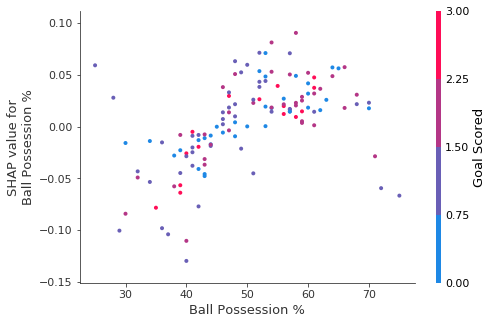

In [3]:
import shap  # librería usada para calcular los valores SHAP

# Crea el objeto que puede calcular valores shap
explainer = shap.TreeExplainer(my_model)

# Calcula los valores shap. Esto es lo que se dibujará
shap_values = explainer.shap_values(X)

# Hacemos el gráfico.
shap.dependence_plot('Ball Possession %', shap_values[1], X, interaction_index="Goal Scored")

Si no proporciona un argumento para `interaccion_index`, Shapley usa un poco de lógica para elegir uno que pueda ser interesante.

Esto no requiere escribir mucho código. Pero el truco con estas técnicas es pensar críticamente sobre los resultados en lugar de escribir código en sí mismo.